<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=300 height=300 align=left class="saturate" >

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2023<br>
<font color=3C99D size=5>
    Practical Assignment 5 - Machine Learning <br>
<font color=696880 size=4>
    Ali Sharifi


____

# Personal Data

In [1]:
# Set your student number
student_number = '99100177'
Name = 'Amirsalar'
Last_Name = 'Safaei Ghaderi'

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
rng = np.random.default_rng(42)

# Question 1: Polynomial Regresrion Implementation (15 points)

<font size=4>
Author: Ali Sharifi
<br/>
<font color=red>
Please run all the cells.
</font>
</font>
<br/>
</div>

In the following section, you will implement a class that performs Polynomial Regression. Follow instructions in the methods' body. Note that your input and output shapes must be the same as instructions.
$$\hat{y} = a_nx^n + \dots + a_1x + a_0$$

In [46]:
class PolynomialRegression:
    """
        The class of polynomial regression.
    """
    def __init__(self, degree):
        """
          initialize parameters you need.
        """
        # Write your code here
        self._degree = degree
        self._coef = np.zeros((degree + 1, ), dtype=np.float64)
    
    @staticmethod
    def PolynomialFeature(X, degree):
        """
          X of the shape (m, 1)
          returns an array A=(a_{ij}) of the shape (m, degree) such that a_{ij} = X_i^j
        """
        res = np.zeros((X.shape[0], degree), dtype=np.float64)
        for i in range(degree):
            res[:, i] = np.power(X.reshape((-1, )), i+1)
        return res
    
    @staticmethod
    def LinearRegression(X, Y):
        """
          X of the shape (m, n)
          y of the shape (m,)
          returns coefficients of linear regression of the shape (n+1,) (extra coefficient for bias term)
        """
        X = PolynomialRegression._concatX(X)
        
        return np.linalg.inv(X.T @ X) @ X.T @ Y
    
    @staticmethod
    def _concatX(X):
        return np.concatenate((np.ones((X.shape[0], 1), dtype=np.float64), X), axis=1)

    def fit(self, X, Y):
        """
          X of the shape (m, n)
          y of the shape (m,)
          returns None
        """
        self._coef = self.LinearRegression(X, Y)

    def predict(self, X):
        """
          X of the shape (m, 1)
          returns an array of the shape (m,)
        """
        return (self._concatX(self.PolynomialFeature(X, self._degree)) @ self._coef.reshape((-1, 1))).reshape((-1, ))

# Question 2: Regressing a Sine Function in Polyomial Functions (10 points)

Consider the underlying function $f^*(X) = \sin(X)$. Generate 15 datasets with 5, 10, 15, 25, and 50 i.i.d samples from the following distribution: (three datasets with each size)
$$
X \sim \text{uniform}(0, 2\pi) \\
Y | X \sim \text{N}(f^*(X), \sigma^2) \\
\text{where } \sigma = .5
$$
Assume we want to train models of degrees 1, 3, 8, 12, and 15 on these datasets. Generate a $5\times 5$ grid of plots. Assume that rows correspond to the dataset size and columns correspond to the degree of model. In each plot, plot the result hypothesis functions from training the corresponding model on the corresponding datasets. In addition plot the underlying function.

In [30]:
def create_dataset(size):
    X = rng.uniform(low=0, high=2 * np.pi, size=size)
    Y = rng.normal(np.sin(X), 0.5)
    return (X, Y)

In [31]:
def plot_models(ax, coefs):
    x = np.linspace(0, 2 * np.pi, 400)
    for idx, coef in enumerate(coefs):
        y = np.polyval(list(reversed(coef)), x)
        ax.plot(x,y, label=f"linear model {idx}")

In [32]:
def plot_truth_func(ax):
    x = np.linspace(0, 2 * np.pi, 400)
    y = np.sin(x)
    ax.plot(x,y, label=f"sin(x)")

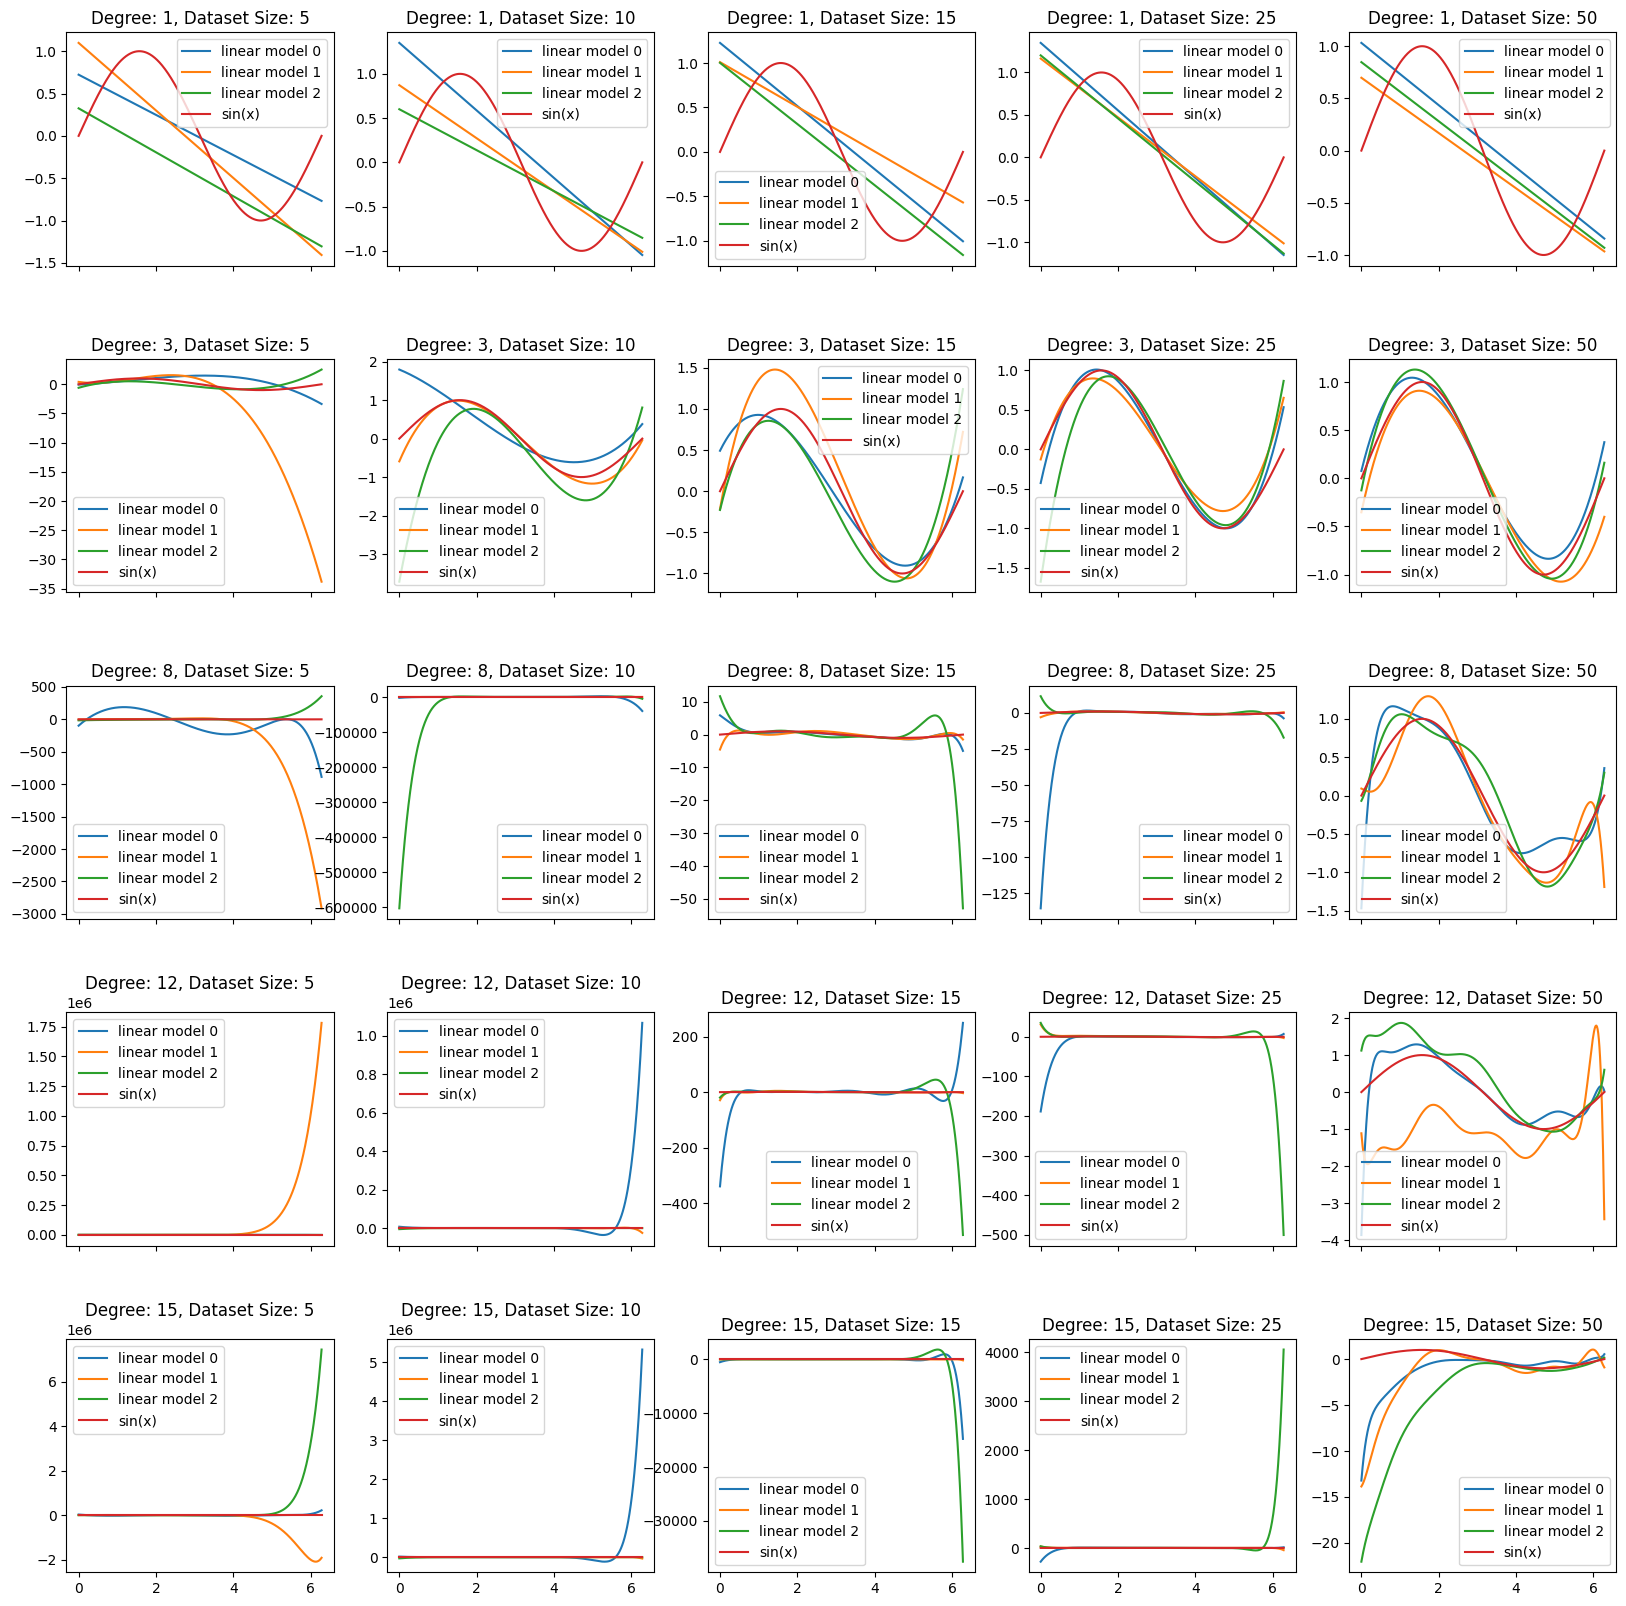

In [33]:
from collections import defaultdict

fig, ax = plt.subplots(5, 5, sharex=True, gridspec_kw=dict(hspace=.4, wspace=.2), figsize=(20, 20))

dataset_sizes = [5, 10, 15, 25, 50]
degrees = [1, 3, 8, 12, 15]

datasets = []

for size in dataset_sizes:
    tmp = [create_dataset(size) for i in range(3)]
    datasets.append(tmp)


res = defaultdict(list)

for degree_idx, degree in enumerate(degrees):
    model = PolynomialRegression(degree)
    for dataset_idx, sub_datasets in enumerate(datasets):
        for X, Y in sub_datasets:
            features = model.PolynomialFeature(X, degree)
            model.fit(features, Y)
            res[(degree_idx, dataset_idx)].append(model._coef)

            
for degree_idx, degree in enumerate(degrees):
    for dataset_idx in range(len(datasets)):
        plot_models(ax[degree_idx,dataset_idx] , res[(degree_idx, dataset_idx)])
        plot_truth_func(ax[degree_idx,dataset_idx])
        ax[degree_idx,dataset_idx].legend()
        ax[degree_idx,dataset_idx].set_title(f"Degree: {degree}, Dataset Size: {dataset_sizes[dataset_idx]}")


Which models are more sensitive to the "noise"? (i.e. If you sample many datasets with the same size and from the same distributions, the trained models on these datasets are very different.) How does the performance of each model change as the number of training samples increase? Does the performace of the linear model improve as the number of samples increase? How about the model of degree 15?

Answer:
- Noise sensitivity:
The Models with higher degree(more flexible models) have higher sensitivity to noise as we go down the rows the linear models get more different from each other
- Performance by sample size:
as the sample size increases no matter what the degree is, the prediction gets closer and closer to the truth value
- Model of degree 15:
even in this model the increase in sample yields better result than smaller sample sizes

# Question 3: Estimating Bias-Variance Trade-off and Drawing Heatmaps (25 points)

## Estmate Bias-Variance Trade-off (20 points)

In this section, you will approximate bias and variance in different classes of polynomial regression models and then find relations between these quantities and n_train_samples and degree.

In [75]:
TEST_SIZE = 400

def bias_variance_estimation(degree, n_train_samples, n_trials=100):
    """
    This function estimates bias and variance of the hypothesis space of polynomials of degree at most d.
    You must perform n_trials, each consists of generating a training set of n_train_samples samples.
    Then you can compute the mean hypothesis and compute bias and variance.
    """
    # generate n_trials datasets each with n_train_samples
    datasets = [create_dataset(n_train_samples) for i in range(int(n_trials))]
    # Write your code here
    x_test = np.linspace(0, 2 * np.pi, TEST_SIZE)
    y_test = np.sin(x_test)
    predictions = np.ndarray((n_trials, TEST_SIZE))
    
    for idx, (x, y) in enumerate(datasets):
        model = PolynomialRegression(degree)
        x = model.PolynomialFeature(x.reshape((-1, 1)), degree)
        model.fit(x, y)
        predictions[idx] = model.predict(x_test.reshape((-1, 1))).reshape((-1, ))

    bias = np.mean(np.mean((predictions - y_test)**2, axis=1))

    variance = np.mean(np.var(predictions, axis=0))

    return bias, variance

## Drawing Heatmaps (5 points)

Now, estimate bias and variance for a model of degree $d$ trained on $n$ samples for values of $d$ and $n$ in the previous section. Then show the results for bias and variance separately as heat maps. (If values of bias and variance are very large, you can use a logarithmic scale.)

In [76]:
data_bias = np.zeros((len(degrees), len(dataset_sizes)), dtype=np.float64)
data_var = np.zeros((len(degrees), len(dataset_sizes)), dtype=np.float64)
for degree_idx, degree in enumerate(degrees):
    for data_set_idx, dataset_size in enumerate(dataset_sizes):
        bias, variance = bias_variance_estimation(degree, dataset_size)
        data_bias[degree_idx, data_set_idx] = bias
        data_var[degree_idx, data_set_idx] = variance

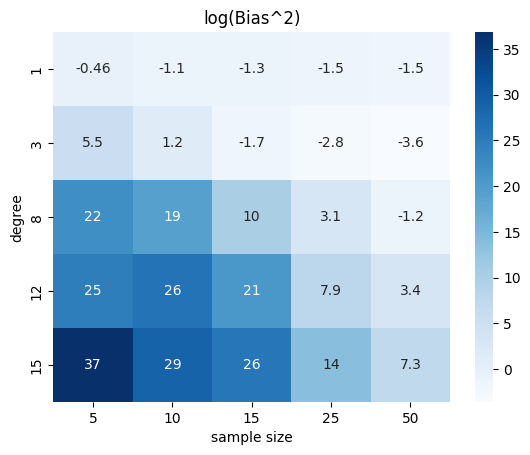

In [78]:
ax = sns.heatmap(np.log(data_bias), cmap="Blues", annot=True)
ax.set_title("log(Bias^2)")
ax.set_ylabel("degree")
ax.set_xlabel("sample size")
ax.set_yticklabels(degrees)
ax.set_xticklabels(dataset_sizes)

plt.show()

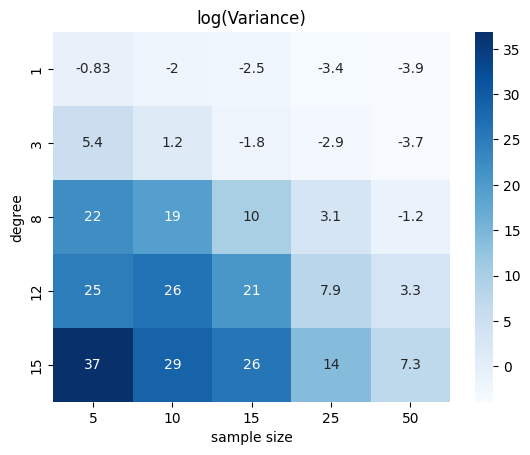

In [79]:
ax = sns.heatmap(np.log(data_var), cmap="Blues", annot=True)
ax.set_title("log(Variance)")
ax.set_ylabel("degree")
ax.set_xlabel("sample size")
ax.set_yticklabels(degrees)
ax.set_xticklabels(dataset_sizes)

plt.show()

Fixing the `degree`, how does bias (or variance) change as the `n_train_samples` increase? Similarly, fixing the `n_train_samples`, how does bias (or variance) change as the `degree` increase? Assume that you have a large dataset. Do you prefer to use a "complex" model or a "simple" model? Why?

answer:
- Fixing degree:
    - bias: the bias generaly decreases because more samples means less noise effect(assume a locality with lot of samples it mitigates the noise)
    - variance: the variance decreases as well because models have more constraint on them and can't freely change
- Fixing sample size:
    - bias: the bias decreases until some point because the truth distribution is more felxible than a linear model can fit nicely. but after some point(degree>=8) the model captures the noise instead of truth function and bias increases. 
    - variance: the variance generaly increases because of the flexibility of the model and having fixed constraints(samples).